In [83]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm 

from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import NMF
from sklearn.metrics import confusion_matrix, SCORERS
from sklearn.utils.multiclass import unique_labels

from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.stats import chi2_contingency


pd.set_option('display.max_columns', None, 'display.max_rows', None)

In [229]:
imagepath = Path('../images')
datapath = Path('../data')
labs = 'labels_lower.csv'
full = 'cleaned_full_1.csv'
survey = 'features_not_scaled.csv'

In [230]:
full_df = pd.read_csv(datapath/full)
feat_df = pd.read_csv(datapath/survey)
label_df = pd.read_csv(datapath/labs)

# Create entire flow:
1. Hold out a section from the the features df
2. Get top questions
3. Dendogram
4. Get clusters
5. Create DF with target counts for each cluter
6. Add chi2 p-value for each cluster

In [237]:
def get_question_text(colname, label_df=label_df):
    '''Get column description'''
    
    cond = label_df['Variable Name'] == colname
    idx = label_df.index[cond].tolist()[0]
    text = label_df.iloc[idx]['Question text']
    
    return text

In [231]:
def nmf_results(df, n_topics=7, top_ques=10, verbose=False): 
    
    X = MinMaxScaler().fit_transform(df)  
    
    nmf = NMF(n_components=n_topics, random_state=0,
              alpha=.3, l1_ratio=.5).fit(X)

    # W matrix maps each row (person) from input matrix to topic vector -> shape(m, n_topics)
    W = nmf.transform(X)

    # For each row/person, grab the column indices with highest values
    # top_3_per_person = W.argsort()[:,-3:][:,::-1]

    # topics is the H matrix, mapping each topic to feature (question) -> shape (n_topics, p)
    topics = nmf.components_
    
    topic_questions = []
    
    for i, topic in enumerate(topics):
        topidxs = np.argsort(topic)[::-1][:top_ques]
        toplist = [(round(topic[i], 2), colname, get_question_text(colname)) 
                   for i, colname in zip(topidxs, df.columns[topidxs])]
        to_string = ['{} -> {} -> {}'.format(*tup) for tup in toplist]
        topques = '\n'.join(to_string)
        topic_questions.append(toplist)
        if verbose:
            print(f'*****Topic: {i}*****\n**Top Questions:\n{topques}\n')
        
    return nmf, W, topic_questions

In [232]:
def h_cluster(W, thresh=8):
    X = MinMaxScaler().fit_transform(W)
    Z = linkage(X, method='ward')

    fig, ax = plt.subplots(figsize=(16,7))
    dn = dendrogram(Z, color_threshold=thresh, no_labels=True, ax=ax)
    ax.set_ylabel('Distance')
    ax.set_xlabel('People')
    ax.set_title(f'Hierarchical Clustering on W matrix with {W.shape[1]} topics')
    plt.savefig(imagepath/f'dendo_{W.shape[1]}_topics.png')
    
    labels = fcluster(Z, t=thresh, criterion='distance')
    
    return labels

In [233]:
def chi2_to_df(df, u_labels):
    for label in u_labels:
        to_col = []
        Cx = df[df.cluster==label].iloc[:,1:4].values
        
        for c in u_labels:
            Cy = df[df.cluster==c].iloc[:,1:4].values
            chi2, p, ddof, expected = chi2_contingency([Cx,Cy])
            to_col.append(round(p, 2))
        
        df[f'vs {label}'] = to_col
            
    return df

In [244]:
def total(feat_df, full_df, n_topics=7, thresh=8, holdout='swb'):
    keep = [c for c in df.columns if holdout not in c]
    target = holdout + '_target'

    nmf, W, topic_questions = nmf_results(feat_df[keep], 
                                          n_topics=n_topics, 
                                          top_ques=10, 
                                          verbose=True)

    labels = h_cluster(W, thresh=thresh)

    u_labels, count = np.unique(labels, return_counts=True)

    target_df = pd.DataFrame()

    for label in u_labels:
        cond = (labels == label)
        s = full_df.loc[cond,:][target].value_counts().sort_index()
        target_df = target_df.append(s, ignore_index=True)
    target_df.insert(0, 'cluster', u_labels)

    target_df = chi2_to_df(target_df, u_labels)

    return target_df

*****Topic: 0*****
**Top Questions:
2.54 -> belong_1 -> If other people don't seem to accept me, I don't let it bother me.
2.42 -> moa2#2_1 -> Make independent decisions
2.26 -> efficacy_4 -> I am confident that I could deal efficiently with unexpected events.
2.26 -> efficacy_5 -> Thanks to my resourcefulness, I know how to handle unforeseen situations.
2.24 -> efficacy_6 -> I can solve most problems if I invest the necessary effort.
2.23 -> efficacy_10 -> I can usually handle whatever comes my way.
2.23 -> belong_7 -> Being apart from my friends for long periods of time does not bother me.
2.23 -> moa2#1_1 -> Make independent decisions
2.22 -> efficacy_7 -> I can remain calm when facing difficulties because I can rely on my coping abilities.
2.21 -> efficacy_1 -> I can always manage to solve difficult problems if I try hard enough.

*****Topic: 1*****
**Top Questions:
3.32 -> mindful_12 -> I drive places on â€˜automatic pilotâ€™ and then wonder why I went there.
3.13 -> mindful_7 -> 

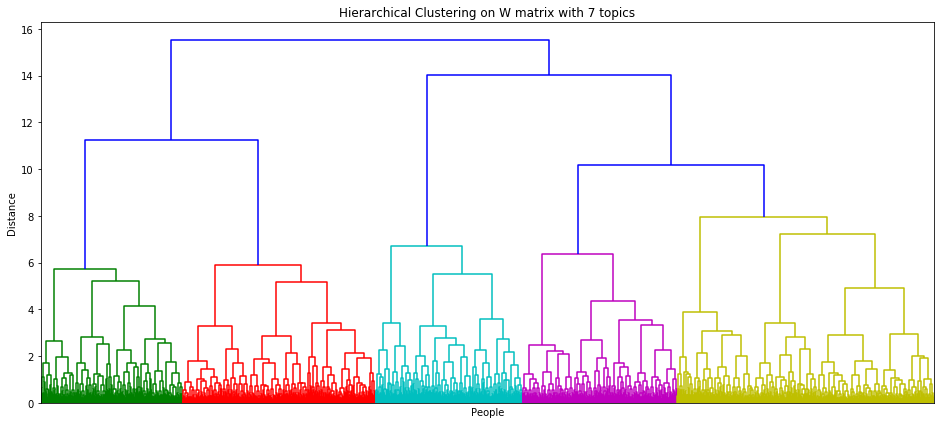

In [245]:
swb_df = total(feat_df, full_df, n_topics=7, thresh=8, holdout='swb')

In [246]:
swb_df

,cluster,high,low,neutral,vs 1,vs 2,vs 3,vs 4,vs 5
0,1,155.0,72.0,221.0,1.0,0.00,0.00,0.00,0.00
1,2,330.0,22.0,260.0,0.0,1.00,0.41,0.00,0.00
2,3,266.0,12.0,186.0,0.0,0.41,1.00,0.00,0.00
3,4,211.0,38.0,241.0,0.0,0.00,0.00,1.00,0.38
4,5,348.0,81.0,383.0,0.0,0.00,0.00,0.38,1.00
